# eICU data exploration

Query results can be extracted like so:

```qr = get_query_result(user="dtank", database="eicu", query="SELECT count(*) FROM patient;")```

CSV files of certain data can be extracted like so:

```extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/noteTRY.csv", variablestring="patientUnitStayID, notePath, noteText", table="note")```

In [1]:
import pandas as pd
from pandas import option_context
import numpy as np
import matplotlib.pyplot as plt
# !pip install tableone
from tableone import TableOne, load_dataset
# !pip install icd9cms
from icd9cms.icd9 import search

from dataExtraction import get_query_result, extract_csv, get_df
from datavisualization import xmostcommon_doubleplot, xmostcommon_df

## Patient characteristics

In [2]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv",
            variablestring="patientunitstayid, uniquePid, gender, age, ethnicity, admissionHeight, hospitalDischargeStatus, unitType, admissionWeight, unitDischargeStatus", 
            table="patient")

COPY 200859
data extracted


### Patient characteristics statistics table
We extract and preprocess the data, then use the [tableone](https://pypi.org/project/tableone/) package to make a patient characteristics table for the ICU mortality. 

In [3]:
patientChar = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv")
patientChar['age'] = patientChar['age'].replace("> 89", "89") # replace all > 89 with 89 entries 
patientChar['age'] = patientChar['age'].astype('float') # convert age from strings to floats

# renaming conventions
patientChar['gender'] = patientChar['gender'].replace("Other", "Other/Unknown") 
patientChar['gender'] = patientChar['gender'].replace("Unknown", "Other/Unknown") 

patientChar['hospitaldischargestatus'] = patientChar['hospitaldischargestatus'].replace('Alive', 'Alive at hospital discharge')
patientChar['hospitaldischargestatus'] = patientChar['hospitaldischargestatus'].replace('Expired', 'Dead at hospital discharge')

patientChar['unitdischargestatus'] = patientChar['unitdischargestatus'].replace('Alive', 'Alive at ICU discharge')
patientChar['unitdischargestatus'] = patientChar['unitdischargestatus'].replace('Expired', 'Dead at ICU discharge')

# only for unique patients
patientChar = patientChar.drop_duplicates(subset='uniquepid')
patientChar

patientunitstayid  uniquepid  gender   age         ethnicity  \
0                  141168  002-34851  Female  70.0         Caucasian   
1                  141178  002-33870  Female  52.0         Caucasian   
3                  141194   002-5276    Male  68.0         Caucasian   
4                  141196  002-37665    Male  71.0         Caucasian   
6                  141203  002-23234  Female  77.0         Caucasian   
...                   ...        ...     ...   ...               ...   
200852            3353216   035-2734  Female  50.0  African American   
200854            3353235  035-16382    Male  50.0         Caucasian   
200855            3353237    035-751  Female  79.0         Caucasian   
200857            3353254  035-19511    Male  81.0         Caucasian   
200858            3353263  035-22638    Male  35.0  African American   

        admissionheight      hospitaldischargestatus      unittype  \
0                 152.4   Dead at hospital discharge  Med-Surg ICU   
1                 162.6  Alive at hospital discharge  Med-Surg ICU   
3                 180.3  Alive at hospital discharge         CTICU   
4                 162.6  Alive at hospital discharge  Med-Surg ICU   
6                 160.0  Alive at hospital discharge  Med-Surg ICU   
...                 ...                          ...           ...   
200852            165.1  Alive at hospital discharge         CTICU   
200854            175.3  Alive at hospital discharge   Cardiac ICU   
200855            162.6  Alive at hospital discharge          MICU   
200857            185.4  Alive at hospital discharge  Med-Surg ICU   
200858            182.9  Alive at hospital discharge          MICU   

        admissionweight     unitdischargestatus  
0                  84.3   Dead at ICU discharge  
1                  54.4  Alive at ICU discharge  
3                  73.9  Alive at ICU discharge  
4                   NaN  Alive at ICU discharge  
6                  70.2  Alive at ICU discharge  
...                 ...                     ...  
200852             55.4  Alive at ICU discharge  
200854             90.0  Alive at ICU discharge  
200855             78.4  Alive at ICU discharge  
200857             83.9  Alive at ICU discharge  
200858            100.8  Alive at ICU discharge  

[139367 rows x 10 columns]

Basic preprocessing for basic patient characteristic statistics

In [4]:
# variables for the tableone package
columns = ['gender', 'age', 'ethnicity', 'admissionheight', 'admissionweight', 'unittype']
categorical = ['gender', 'ethnicity', 'unittype']
labels = {'gender' : 'Gender', 
          'age' : 'Age', 
          'ethnicity' : 'Ethnicity', 
          'admissionheight' : 'Height', 
          'admissionweight' : 'Weight', 
          'unittype' : 'ICU Unit'}

patientCharTableICU = TableOne(patientChar, columns=columns, categorical=categorical, rename=labels, 
                               label_suffix=True, nonnormal=['age'], groupby='unitdischargestatus', pval=True)

In [5]:
patientCharTableICU
# print(patientCharTable.tabulate(tablefmt = 'latex')) # print a latex formatted table

Grouped by unitdischargestatus                                                                       
                                                            Missing           Overall Alive at ICU discharge Dead at ICU discharge P-Value
n                                                                              139367                 130454                  8898        
Gender, n (%)       Female                                      111      64038 (46.0)           59974 (46.0)           4055 (45.6)  <0.001
                    Male                                                 75176 (54.0)           70346 (54.0)           4824 (54.3)        
                    Other/Unknown                                            42 (0.0)               29 (0.0)              13 (0.1)        
Age, median [Q1,Q3]                                              82  65.0 [53.0,77.0]       65.0 [52.0,76.0]      71.0 [59.0,81.0]  <0.001
Ethnicity, n (%)    African American                           1780      14672 (10.7)           13771 (10.7)            901 (10.3)   0.167
                    Asian                                                  2338 (1.7)             2187 (1.7)             151 (1.7)        
                    Caucasian                                           107724 (78.3)          100814 (78.3)           6895 (78.7)        
                    Hispanic                                               5233 (3.8)             4933 (3.8)             300 (3.4)        
                    Native American                                         964 (0.7)              902 (0.7)              62 (0.7)        
                    Other/Unknown                                          6656 (4.8)             6199 (4.8)             457 (5.2)        
Height, mean (SD)                                              3153      169.3 (13.9)           169.3 (13.8)          168.6 (15.0)  <0.001
Weight, mean (SD)                                              8170       83.9 (26.9)            84.0 (26.8)           81.8 (27.5)  <0.001
ICU Unit, n (%)     CCU-CTICU                                     0       11404 (8.2)            10720 (8.2)             682 (7.7)  <0.001
                    CSICU                                                  5164 (3.7)             4905 (3.8)             259 (2.9)        
                    CTICU                                                  4597 (3.3)             4438 (3.4)             158 (1.8)        
                    Cardiac ICU                                            9362 (6.7)             8632 (6.6)             730 (8.2)        
                    MICU                                                  11721 (8.4)            10689 (8.2)           1029 (11.6)        
                    Med-Surg ICU                                         77928 (55.9)           72924 (55.9)           4996 (56.1)        
                    Neuro ICU                                             10678 (7.7)            10136 (7.8)             542 (6.1)        
                    SICU                                                   8513 (6.1)             8010 (6.1)             502 (5.6)        
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: gender.

### Patient characteristics: mortality per ethnicity and age plot
We preprocess the patient characteristics data, extract the amount of deaths per ethnicity and age group, divide these by their total ethnicity amount (ethnicity normalized) to get the ethnicity normalized mortality rate per 1000 people. 

In [12]:
patientCharPlot = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv")
patientCharPlot = patientCharPlot.drop_duplicates(subset='uniquepid') # only for unique patients

# make age categories
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(0, 20))], '0-20'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(20, 30))], '20-30'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(30, 40))], '30-40'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(40, 50))], '40-50'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(50, 60))], '50-60'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(60, 70))], '60-70'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(70, 80))], '70-80'))
lastcat = [str(x) for x in list(range(80, 90))]
lastcat.append('> 89')
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys(lastcat, '80+'))

# group by ethnicity and age and find the value counts
mortEthAge = patientCharPlot.groupby(['ethnicity', 'age'], as_index=False).unitdischargestatus.value_counts()
mortEthAge = mortEthAge[mortEthAge['unitdischargestatus'] == 'Expired']

# find the total amount per ethnicity category for normalization purposes
AfAmTotal = len(patientChar[patientChar['ethnicity'] == 'African American']['ethnicity'])
AsianTotal = len(patientChar[patientChar['ethnicity'] == 'Asian']['ethnicity'])
CaucasTotal = len(patientChar[patientChar['ethnicity'] == 'Caucasian']['ethnicity'])
NatAmTotal = len(patientChar[patientChar['ethnicity'] == 'Native American']['ethnicity'])
UnknTotal = len(patientChar[patientChar['ethnicity'] == 'Other/Unknown']['ethnicity'])

# find the normalized values for the bar plot
AfAm = (mortEthAge[mortEthAge['ethnicity'] == 'African American']['count']/AfAmTotal*1000).to_list()
Asian = (mortEthAge[mortEthAge['ethnicity'] == 'Asian']['count']/AsianTotal*1000).to_list()
Caucas = (mortEthAge[mortEthAge['ethnicity'] == 'Caucasian']['count']/CaucasTotal*1000).to_list()
NatAm = (mortEthAge[mortEthAge['ethnicity'] == 'Native American']['count']/NatAmTotal*1000).to_list()
Unkn = (mortEthAge[mortEthAge['ethnicity'] == 'Other/Unknown']['count']/UnknTotal*1000).to_list()

Make a plot for all ethnicities and ages, for their normalized icu mortality per 1000 people.

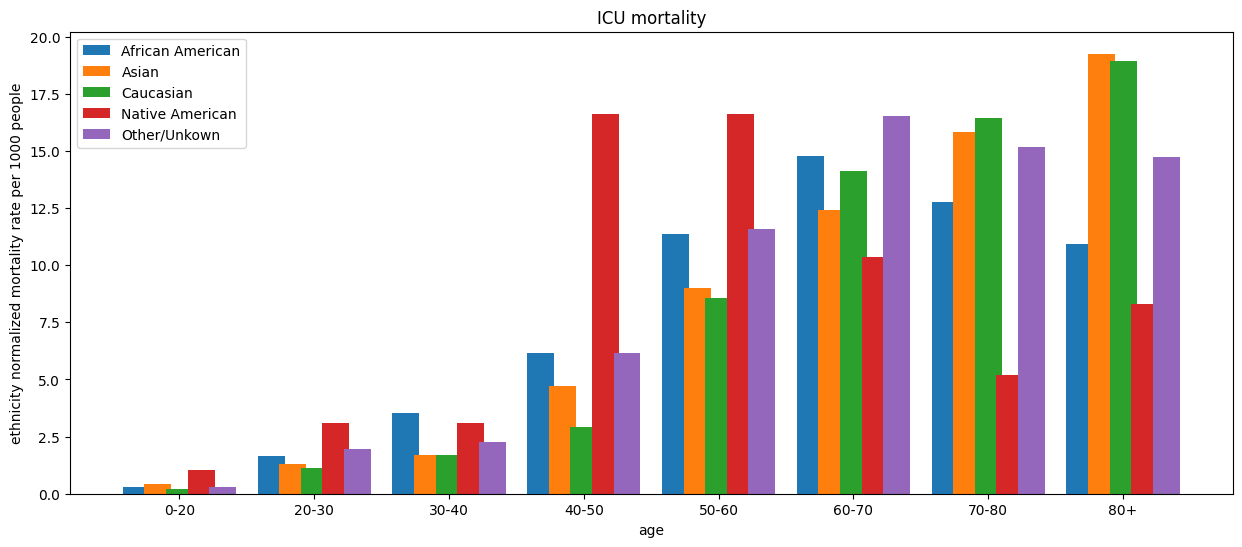

In [14]:
X = np.arange(8)
fig = plt.figure(figsize=(15,6))
margin = 0.8
plt.bar(X + -0.4 * margin, AfAm, width = 0.2)
plt.bar(X + -0.2 * margin, Asian, width = 0.2)
plt.bar(X , Caucas, width = 0.2)
plt.bar(X + 0.2 * margin, NatAm, width = 0.2)
plt.bar(X + 0.4 * margin, Unkn, width = 0.2)
plt.xlabel('age')
plt.ylabel('ethnicity normalized mortality rate per 1000 people')
plt.legend(labels=['African American', 'Asian', 'Caucasian', 'Native American', 'Other/Unkown'])
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7), ('0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+'))
plt.title('ICU mortality')

plt.show()

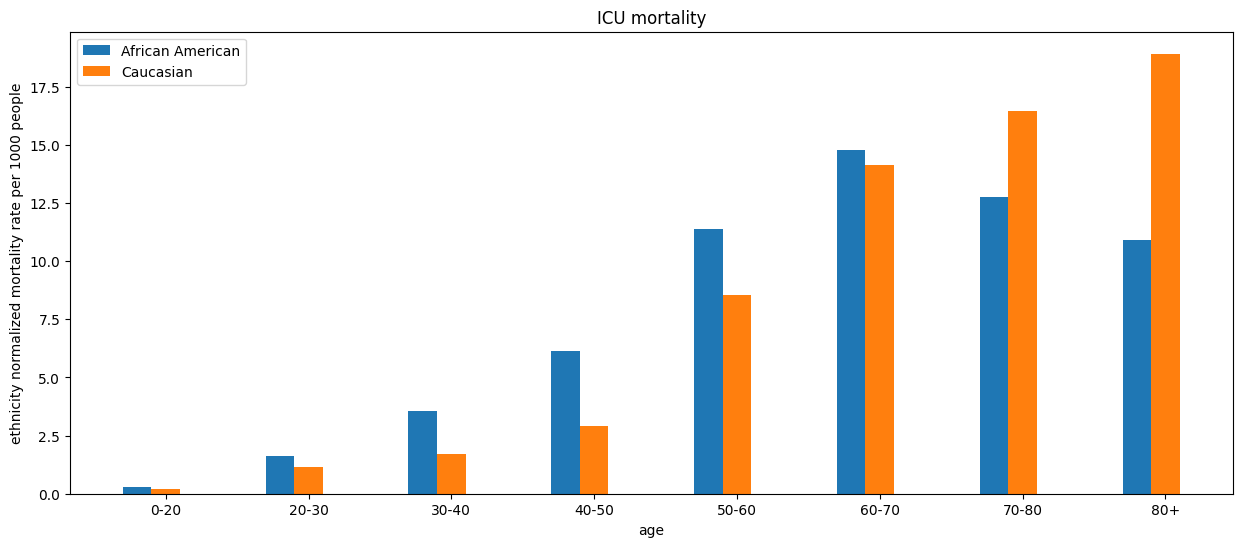

In [15]:
X = np.arange(8)
fig = plt.figure(figsize=(15,6))
margin = 0.8
plt.bar(X + -0.2, AfAm, width = 0.2)
plt.bar(X , Caucas, width = 0.2)
plt.xlabel('age')
plt.ylabel('ethnicity normalized mortality rate per 1000 people')
plt.legend(labels=['African American', 'Caucasian'])
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7), ('0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+'))
plt.title('ICU mortality')

plt.show()

## (Admission) Diagnoses

In [14]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/diagnoses.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.apacheAdmissionDx, patient.hospitalDischargeStatus, patient.unitDischargeStatus, diagnosis.diagnosisString, diagnosis.ICD9Code", table="patient, diagnosis")

COPY 2710672
data extracted


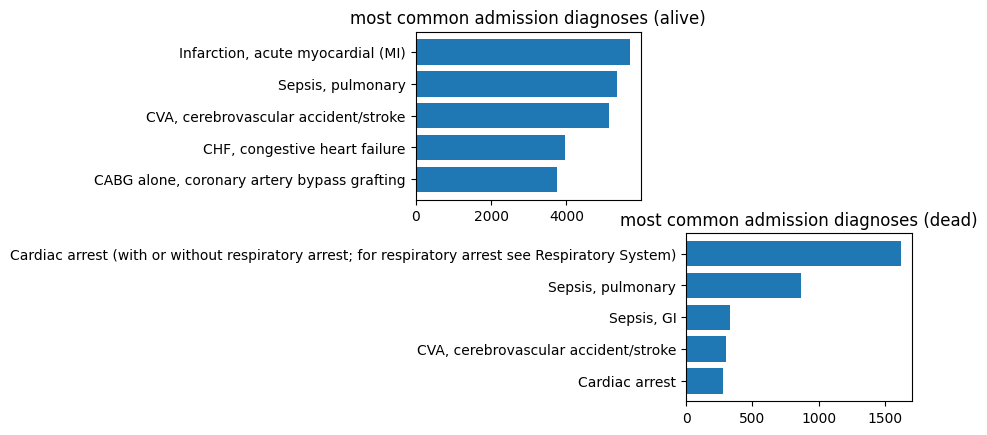

In [16]:
diagnoses = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/diagnoses.csv")
diagnoses = diagnoses.drop_duplicates(subset='uniquepid') # get unique patients
diagnoses['icd9code'] = diagnoses['icd9code'].str.split(',').str[0] # get only the first icd9 code

# most common admission diagnoses
admdiag = diagnoses.groupby('unitdischargestatus', as_index=False)['apacheadmissiondx'].value_counts().reset_index(drop=True)
admdiag_alive = admdiag[admdiag['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
admdiag_dead = admdiag[admdiag['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# plot most common admission diagnoses
xmostcommon_doubleplot(admdiag_alive, admdiag_dead, 'apacheadmissiondx', "most common admission diagnoses")

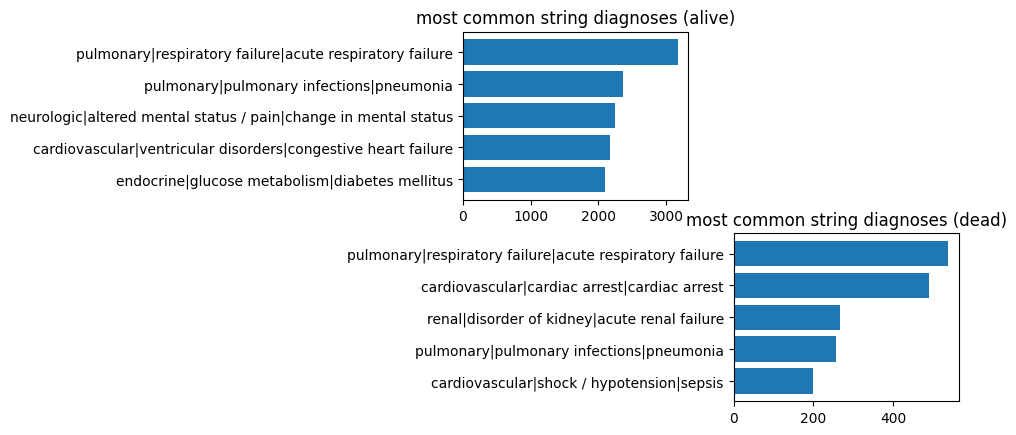

In [17]:
# most common diagnosis strings
diagstring = diagnoses.groupby('unitdischargestatus', as_index=False)['diagnosisstring'].value_counts().reset_index(drop=True)
diagstring_alive = diagstring[diagstring['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
diagstring_dead = diagstring[diagstring['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# plot the most common diagnosis strings
xmostcommon_doubleplot(diagstring_alive, diagstring_dead, 'diagnosisstring', "most common string diagnoses")

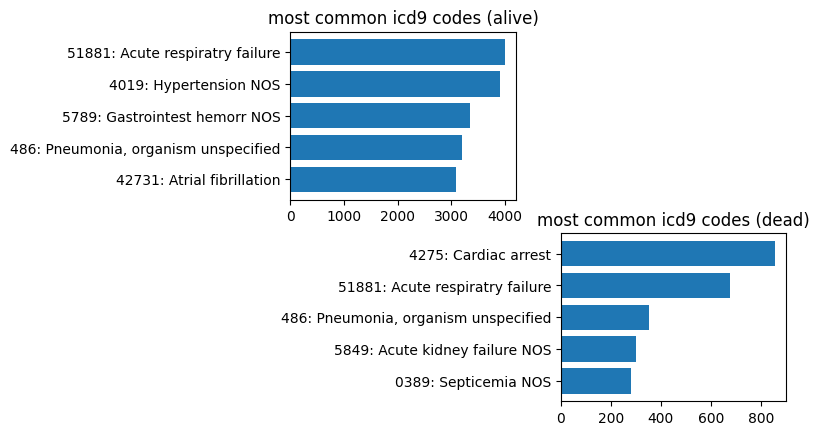

In [18]:
# helper function to convert icd9 code to string
def code_to_string(x):
    try: 
        codeandtext = str(search(x)).split(":")[0:2]
        return codeandtext[0] + ": " + codeandtext[1]
    except:
        return 'None'

# most common icd9 code diagnosis
icd9code = diagnoses.groupby('unitdischargestatus', as_index=False)['icd9code'].value_counts().reset_index(drop=True)
icd9code_alive = icd9code[icd9code['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
icd9code_dead = icd9code[icd9code['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)
icd9code_alive['icd9codetostring'] = icd9code['icd9code'].apply(code_to_string)
icd9code_dead['icd9codetostring'] = icd9code['icd9code'].apply(code_to_string)

xmostcommon_doubleplot(icd9code_alive, icd9code_dead, 'icd9codetostring', "most common icd9 codes")

## Hospital information

In [19]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/hospital.csv", variablestring="patient.hospitalID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, hospital.teachingstatus, hospital.region", table="patient, hospital", joinon='hospitalID')

COPY 200859
data extracted


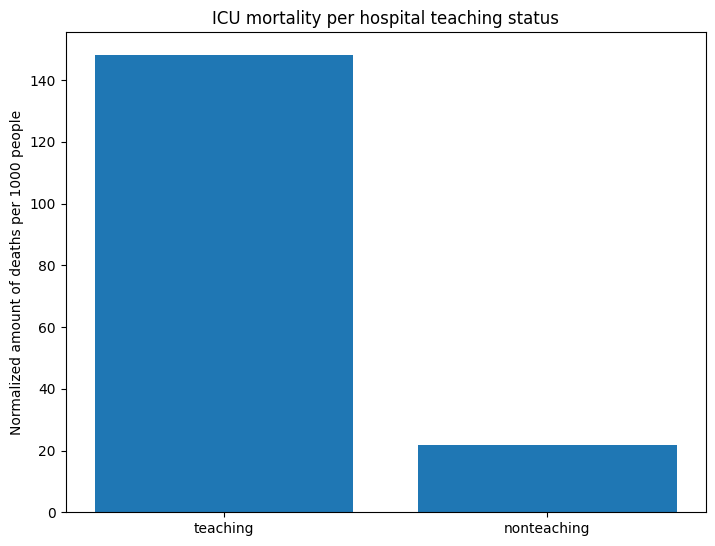

In [21]:
hospital = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/hospital.csv")

# find the amount of dead patients per hospital status
hospital_teachingstatus = hospital.groupby(['teachingstatus'], as_index=False).unitdischargestatus.value_counts()
hospital_teachingstatus = hospital_teachingstatus[hospital_teachingstatus['unitdischargestatus']=='Expired']

# find the total amount of patients per hospital status
total_nonteaching = (hospital['teachingstatus']=='f').sum()
total_teaching = (hospital['teachingstatus']=='t').sum()

# calculate the mortality per 1000 people per hospital status
mortality_teaching = hospital_teachingstatus['count'][1]/total_teaching*1000
mortality_nonteaching = hospital_teachingstatus['count'][3]/total_nonteaching*1000

# make the plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
teachingstatus = ['teaching', 'nonteaching']
norm_mort = [mortality_teaching, mortality_nonteaching]
ax.bar(teachingstatus, norm_mort)
ax.set_ylabel('Normalized amount of deaths per 1000 people')
plt.title('ICU mortality per hospital teaching status')
plt.show()

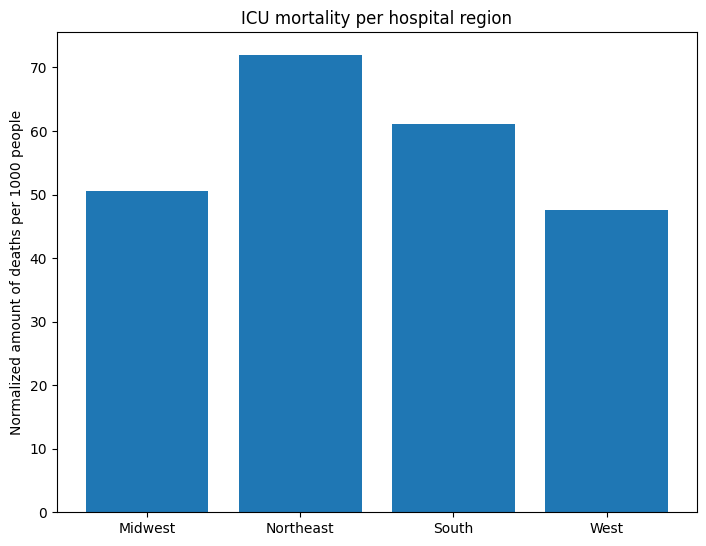

In [22]:
# gather data filtered on hospital region and amount of deaths
hospital_region = hospital.groupby(['region'], as_index=False).unitdischargestatus.value_counts()
hospital_region = hospital_region[hospital_region['unitdischargestatus']=='Expired']

# find total of patients per region
total_midwest = (hospital['region']=='Midwest').sum()
total_northeast = (hospital['region']=='Northeast').sum()
total_south = (hospital['region']=='South').sum()
total_west = (hospital['region']=='West').sum()

# calculate the normalized amount of deaths per region
mortality_midwest = hospital_region['count'][1]/total_midwest*1000
mortality_northeast = hospital_region['count'][3]/total_northeast*1000
mortality_south = hospital_region['count'][5]/total_south*1000
mortality_west = hospital_region['count'][7]/total_west*1000

# make the plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
region = hospital_region['region']
norm_mort = [mortality_midwest, mortality_northeast, mortality_south, mortality_west]
ax.bar(region, norm_mort)
ax.set_ylabel('Normalized amount of deaths per 1000 people')
plt.title("ICU mortality per hospital region")
plt.show()

## Past History

In [21]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/pastHistory.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, pastHistory.pasthistoryvaluetext", table="patient, pasthistory")

COPY 1149180
data extracted


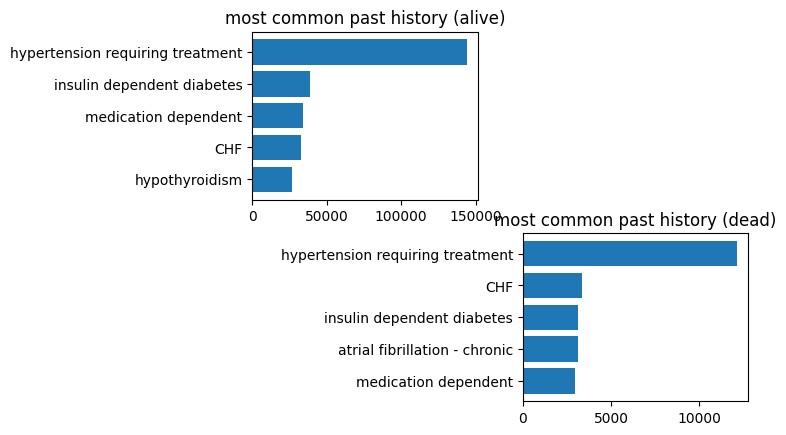

In [23]:
pastHistory = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/pastHistory.csv')
pastHistory = pastHistory[pastHistory.pasthistoryvaluetext != 'Performed'] # remove the 'performed' value rows since it does not give insightful information

# find the most common past history for alive and expired patients
pasthist = pastHistory.groupby('unitdischargestatus', as_index=False)['pasthistoryvaluetext'].value_counts().reset_index(drop=True)
pasthist_alive = pasthist[pasthist['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
pasthist_dead = pasthist[pasthist['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# make the plot
xmostcommon_doubleplot(pasthist_alive, pasthist_dead, 'pasthistoryvaluetext', 'most common past history')

## Treatment

In [23]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/treatment.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, treatment.treatmentstring", table="patient, treatment")

COPY 3688745
data extracted


In [25]:
treatment = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/treatment.csv')
treatment['treatmentvalue'] = treatment['treatmentstring'].str.split('|').str[-1] # take only the treatment value (last one in treatment path)

# show the top 20 treatment amounts per patient
treatmentAmount = treatment.uniquepid.value_counts()
treatmentAmount = treatmentAmount.value_counts().rename_axis('treatment_amount').reset_index(name='counts')
treatmentAmount[:20]

treatment_amount  counts
0                  1   13830
1                  2   11791
2                  3    9475
3                  4    7993
4                  5    6347
5                  6    5472
6                  7    4475
7                  8    4003
8                  9    3319
9                 10    3012
10                11    2428
11                12    2314
12                14    2014
13                13    1866
14                15    1579
15                16    1575
16                18    1372
17                17    1316
18                20    1208
19                19    1090

In [26]:
print('maximum treatment amounts:', treatmentAmount['treatment_amount'].max())

maximum treatment amounts: 8123


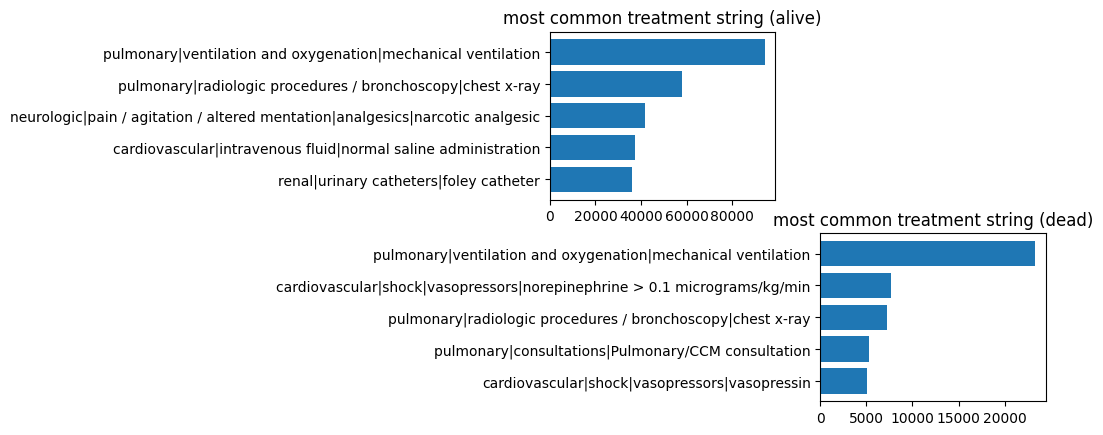

In [27]:
treatmentstring = treatment.groupby('unitdischargestatus', as_index=False)['treatmentstring'].value_counts().reset_index(drop=True)
treatmentstring_alive = treatmentstring[treatmentstring['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
treatmentstring_dead = treatmentstring[treatmentstring['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# make the plot
xmostcommon_doubleplot(treatmentstring_alive, treatmentstring_dead, 'treatmentstring', 'most common treatment string')

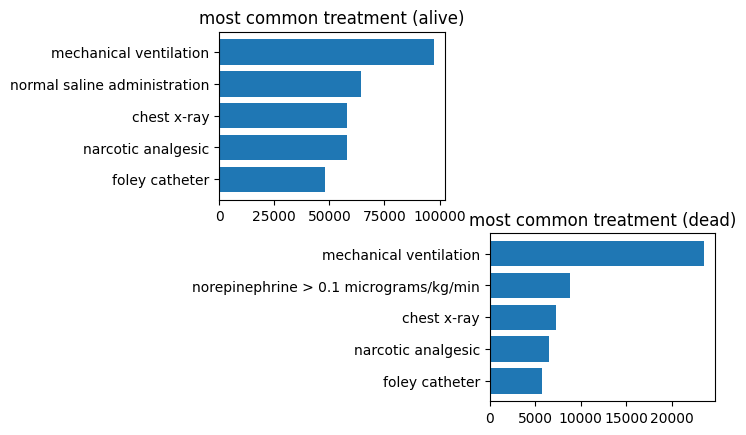

In [28]:
treatmentvalue = treatment.groupby('unitdischargestatus', as_index=False)['treatmentvalue'].value_counts().reset_index(drop=True)
treatmentvalue_alive = treatmentvalue[treatmentvalue['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
treatmentvalue_dead = treatmentvalue[treatmentvalue['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

xmostcommon_doubleplot(treatmentvalue_alive, treatmentvalue_dead, 'treatmentvalue', 'most common treatment')

## Predicted and actual mortality

In [28]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/apachepatientresult.csv", variablestring="apachescore, predictedicumortality, actualicumortality, predictedhospitalmortality, actualhospitalmortality", table="apachepatientresult")

COPY 297064
data extracted


In [29]:
apachepatientresult = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/apachepatientresult.csv")
icumortality_apache = apachepatientresult.groupby('actualicumortality')['apachescore'].mean()
icumortality_mortality = apachepatientresult.groupby('actualicumortality')['predictedicumortality'].mean()

print(icumortality_apache)
print()
print(icumortality_mortality)

actualicumortality
ALIVE      52.423158
EXPIRED    93.339060
Name: apachescore, dtype: float64

actualicumortality
ALIVE      0.029384
EXPIRED    0.304714
Name: predictedicumortality, dtype: float64


## Admission drugs

In [30]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/admissiondrugs.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, admissionDrug.drugname, admissionDrug.drughiclseqno", table="patient, admissiondrug")

COPY 874920
data extracted


In [30]:
admissiondrug = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/admissiondrugs.csv")
admissiondrug['codeanddrug'] = admissiondrug['drughiclseqno'].astype('string') + ': ' + admissiondrug['drugname'] # show both drug code and drug name in the same column
admissiondrug

patientunitstayid  uniquepid hospitaldischargestatus  \
0                  253168  003-27396                   Alive   
1                  253168  003-27396                   Alive   
2                  253168  003-27396                   Alive   
3                  253168  003-27396                   Alive   
4                  253168  003-27396                   Alive   
...                   ...        ...                     ...   
874915            3340476  035-17594                   Alive   
874916            3340476  035-17594                   Alive   
874917            3340476  035-17594                   Alive   
874918            3340476  035-17594                   Alive   
874919            3340476  035-17594                   Alive   

       unitdischargestatus                                           drugname  \
0                    Alive  ESCITALOPRAM OXALATE                          ...   
1                    Alive  ESCITALOPRAM OXALATE                          ...   
2                    Alive  ASPIR 81                                      ...   
3                    Alive  ASPIR 81                                      ...   
4                    Alive  AMLODIPINE BESILATE                           ...   
...                    ...                                                ...   
874915               Alive  GENTAMICIN SULFATE                            ...   
874916               Alive  GLYBURIDE                                     ...   
874917               Alive  PEPCID                                        ...   
874918               Alive  VANCOMYCIN                                    ...   
874919               Alive  CALCIUM                                       ...   

        drughiclseqno                                        codeanddrug  
0               24022  24022: ESCITALOPRAM OXALATE                   ...  
1               24022  24022: ESCITALOPRAM OXALATE                   ...  
2                1820  1820: ASPIR 81                                ...  
3                1820  1820: ASPIR 81                                ...  
4                6494  6494: AMLODIPINE BESILATE                     ...  
...               ...                                                ...  
874915           4032  4032: GENTAMICIN SULFATE                      ...  
874916            802  802: GLYBURIDE                                ...  
874917           4521  4521: PEPCID                                  ...  
874918          37442  37442: VANCOMYCIN                             ...  
874919          33229  33229: CALCIUM                                ...  

[874920 rows x 7 columns]

In [31]:
print('avg amount of admission drugs registered:', admissiondrug['uniquepid'].value_counts().mean())
print('maximum amount of admission drugs registered: ', admissiondrug['uniquepid'].value_counts().max())
print('minimum amount of admission drugs registered: ', admissiondrug['uniquepid'].value_counts().min())

avg amount of admission drugs registered: 27.584336969544108
maximum amount of admission drugs registered:  11671
minimum amount of admission drugs registered:  1


In [32]:
# find the most common drugs given to expired patients
xmostcommon_df(admissiondrug, 'unitdischargestatus', 'codeanddrug', 10)

codeanddrug  \
4690  6494: AMLODIPINE BESILATE                                                                                                                                                                                                                                               
4689  2879: PREDNISONE                                                                                                                                                                                                                                                        
4687  2074: ALBUTEROL                                                                                                                                                                                                                                                         
4688  8831: GABAPENTIN                                                                                                                                                                                                                                                        
4686  2849: LEVOTHYROXINE SODIUM                                                                                                                                                                                                                                              
4685  1794: ASPIRIN                                                                                                                                                                                                                                                           
4684  4673: OMEPRAZOLE                                                                                                                                                                                                                                                        
4683  1820: ASPIRIN                                                                                                                                                                                                                                                           
4682   132: LISINOPRIL                                                                                                                                                                                                                                                        
4681  3660: LASIX                                                                                                                                                                                                                                                             

      count  
4690    906  
4689    933  
4687    960  
4688    960  
4686   1169  
4685   1170  
4684   1335  
4683   1399  
4682   1547  
4681   1844

## Active medication

In [ ]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/medication.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, medication.drugname, medication.drughiclseqno", table="patient, medication")

In [33]:
medication = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/medication.csv")

# # show both drug code and drug name in the same column and skip nans
medication['codeandmed'] = medication['drughiclseqno'].astype('string') + ': ' + medication['drugname']
medication = medication.dropna()
medication

patientunitstayid  uniquepid hospitaldischargestatus  \
1                   141178  002-33870                   Alive   
4                   141208  002-34521                   Alive   
6                   141208  002-34521                   Alive   
7                   141208  002-34521                   Alive   
8                   141233   002-8979                   Alive   
...                    ...        ...                     ...   
7301847            3353235  035-16382                   Alive   
7301849            3353235  035-16382                   Alive   
7301850            3353237    035-751                   Alive   
7301851            3353237    035-751                   Alive   
7301852            3353237    035-751                   Alive   

        unitdischargestatus  \
1                     Alive   
4                     Alive   
6                     Alive   
7                     Alive   
8                     Alive   
...                     ...   
7301847               Alive   
7301849               Alive   
7301850               Alive   
7301851               Alive   
7301852               Alive   

                                                  drugname  drughiclseqno  \
1             SENNOSIDES-DOCUSATE SODIUM 8.6-50 MG PO TABS        21772.0   
4                       MAGNESIUM SULFATE 2 G IN NS PREMIX        11249.0   
6        100 ML  -  MAGNESIUM SULFATE IN D5W 10-5 MG/ML...         6306.0   
7             SENNOSIDES-DOCUSATE SODIUM 8.6-50 MG PO TABS        21772.0   
8        100 ML  -  MAGNESIUM SULFATE IN D5W 10-5 MG/ML...         6306.0   
...                                                    ...            ...   
7301847                                DIPHENHYDRAMINE HCL         4480.0   
7301849                                         LISINOPRIL          132.0   
7301850                                         LISINOPRIL          132.0   
7301851                                         LISINOPRIL          132.0   
7301852                                    DOCUSATE SODIUM         1326.0   

                                                codeandmed  
1        21772.0: SENNOSIDES-DOCUSATE SODIUM 8.6-50 MG ...  
4              11249.0: MAGNESIUM SULFATE 2 G IN NS PREMIX  
6        6306.0: 100 ML  -  MAGNESIUM SULFATE IN D5W 10...  
7        21772.0: SENNOSIDES-DOCUSATE SODIUM 8.6-50 MG ...  
8        6306.0: 100 ML  -  MAGNESIUM SULFATE IN D5W 10...  
...                                                    ...  
7301847                        4480.0: DIPHENHYDRAMINE HCL  
7301849                                  132.0: LISINOPRIL  
7301850                                  132.0: LISINOPRIL  
7301851                                  132.0: LISINOPRIL  
7301852                            1326.0: DOCUSATE SODIUM  

[4313577 rows x 7 columns]

In [34]:
print('avg amount of active medication per patient:', medication['uniquepid'].value_counts().mean())
print('maximum amount of active medication per patient: ', medication['uniquepid'].value_counts().max())
print('minimum amount of active medication per patient: ', medication['uniquepid'].value_counts().min())

avg amount of active medication per patient: 38.739252260909396
maximum amount of active medication per patient:  1153
minimum amount of active medication per patient:  1


In [35]:
# find the most common drugs given to expired patients
xmostcommon_df(medication, 'unitdischargestatus', 'codeandmed', 10)

codeandmed  count
1776                                           4842.0: propofol   1582
1775                                  926.0: DEXTROSE 50%-WATER   1599
1774                 8255.0: SODIUM CHLORIDE 0.9 % IV : 1000 ML   1684
1773                                      8255.0: NaCl 0.9% MBP   1797
1772                                      1866.0: ACETAMINOPHEN   1932
1771                                         3660.0: FUROSEMIDE   2015
1770                                          1619.0: MIDAZOLAM   2093
1769                             25386.0: fentaNYL citrate (PF)   2113
1768                               8255.0: SODIUM CHLORIDE 0.9%   2614
1767  8255.0: 1000 ML FLEX CONT : SODIUM CHLORIDE 0.9 % IV SOLN   2858

## Lab tests

In [39]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/lab.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, lab.labname", table="patient, lab")

COPY 39132531
data extracted


In [36]:
lab = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/lab.csv")
lab

patientunitstayid  uniquepid hospitaldischargestatus  \
0                    141178  002-33870                   Alive   
1                    141178  002-33870                   Alive   
2                    141178  002-33870                   Alive   
3                    141178  002-33870                   Alive   
4                    141178  002-33870                   Alive   
...                     ...        ...                     ...   
39132526            3353237    035-751                   Alive   
39132527            3353237    035-751                   Alive   
39132528            3353237    035-751                   Alive   
39132529            3353237    035-751                   Alive   
39132530            3353237    035-751                   Alive   

         unitdischargestatus        labname  
0                      Alive     salicylate  
1                      Alive            RDW  
2                      Alive  total protein  
3                      Alive            MCV  
4                      Alive  Acetaminophen  
...                      ...            ...  
39132526               Alive            MPV  
39132527               Alive         -basos  
39132528               Alive            Hgb  
39132529               Alive         -monos  
39132530               Alive           -eos  

[39132531 rows x 5 columns]

In [37]:
print('avg amount of ordered lab tests per patient:', lab['uniquepid'].value_counts().mean())
print('maximum amount of ordered lab tests per patient: ', lab['uniquepid'].value_counts().max())
print('minimum amount of ordered lab tests per patient: ', lab['uniquepid'].value_counts().min())

avg amount of ordered lab tests per patient: 283.0583295358375
maximum amount of ordered lab tests per patient:  11933
minimum amount of ordered lab tests per patient:  1


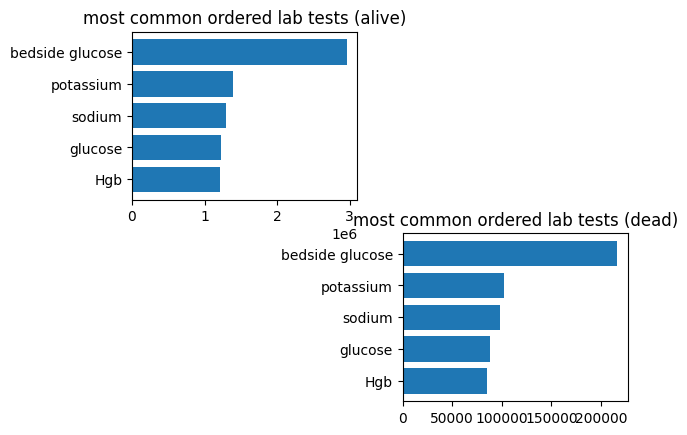

In [38]:
labtest = lab.groupby('unitdischargestatus', as_index=False)['labname'].value_counts().reset_index(drop=True)
labtest_alive = labtest[labtest['unitdischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
labtest_dead = labtest[labtest['unitdischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

xmostcommon_doubleplot(labtest_alive, labtest_dead, 'labname', 'most common ordered lab tests')

## Notes

In [43]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/basicnotes.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, note.notepath, note.notetext", table="patient, note")

COPY 2254179
data extracted


In [39]:
basicnotes = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/basicnotes.csv')
basicnotes

patientunitstayid  uniquepid hospitaldischargestatus  \
0                   167766  002-30280                   Alive   
1                   167766  002-30280                   Alive   
2                   179023  002-62026                   Alive   
3                   179023  002-62026                   Alive   
4                   146410  002-49141                   Alive   
...                    ...        ...                     ...   
2254174            3339418    035-674                   Alive   
2254175            3339418    035-674                   Alive   
2254176            3339418    035-674                   Alive   
2254177            3339418    035-674                   Alive   
2254178            3339418    035-674                   Alive   

        unitdischargestatus  \
0                     Alive   
1                     Alive   
2                     Alive   
3                     Alive   
4                     Alive   
...                     ...   
2254174               Alive   
2254175               Alive   
2254176               Alive   
2254177               Alive   
2254178               Alive   

                                                  notepath      notetext  
0        notes/Progress Notes/Assessment and Plan/View ...    SystemView  
1        notes/Shared/View and Save/Save Options/Print/...             1  
2        notes/Progress Notes/Assessment and Plan/View ...  Problem View  
3        notes/Shared/View and Save/Save Options/Print/...             1  
4        notes/Progress Notes/Assessment and Plan/View ...    SystemView  
...                                                    ...           ...  
2254174  notes/Progress Notes/Allergies / Preadmission ...            No  
2254175  notes/Progress Notes/Review Of Systems/Review ...  NotPerformed  
2254176  notes/Progress Notes/Assessment and Plan/View ...    SystemView  
2254177  notes/Progress Notes/Assessment and Plan/Inclu...    Include Rx  
2254178  notes/Shared/View and Save/Save Options/Print/...             1  

[2254179 rows x 6 columns]

In [40]:
print('avg amount of notes per patient:', basicnotes['uniquepid'].value_counts().mean())
print('maximum amount of notes per patient: ', basicnotes['uniquepid'].value_counts().max())
print('minimum amount of notes per patient: ', basicnotes['uniquepid'].value_counts().min())

avg amount of notes per patient: 16.43239125522128
maximum amount of notes per patient:  2698
minimum amount of notes per patient:  1


In [41]:
print('average amount of notes for dead patients: ', basicnotes.groupby('unitdischargestatus')['uniquepid'].value_counts()['Expired'].mean())
print('average amount of notes for alive patients: ', basicnotes.groupby('unitdischargestatus')['uniquepid'].value_counts()['Alive'].mean())

average amount of notes for dead patients:  19.97348261638185
average amount of notes for alive patients:  15.810856239639154
